<div align="center">

## Regression Project for Maths Score Prediction
### Autor : Vinh Tang

</div>

### Libraries import

In [305]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lazypredict.Supervised import LazyRegressor
import pickle
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score





### ML Pipeline

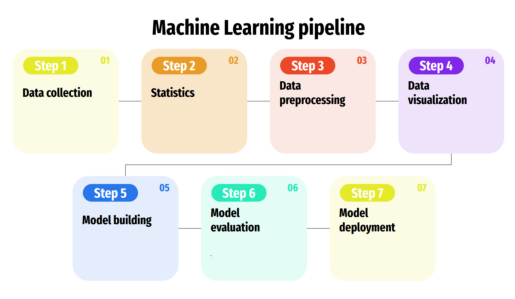

In [306]:
def show_image(filename):
    img = mpimg.imread(filename)
    plt.imshow(img)
    plt.axis('off') 
    plt.show()

show_image("ML_Pipeline.png")

### Step 1 : Data collection : skip because data is already available
### Step between step 1 and step 2: Importing data

In [307]:
df = pd.read_csv("StudentScore.xls")
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77



Here there are three columns of numbers: math score, writing score, reading score and we can choose one of these three columns as target, the other two columns will automatically become numerical feature. 

Here, I choose math score column as target

In [308]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [309]:
df.describe()

,math score,reading score,writing score
count,1000.00,1000.00,1000.00
mean,66.09,69.17,68.05
std,15.16,14.60,15.20
min,0.00,17.00,10.00
25%,57.00,59.00,57.75
50%,66.00,70.00,69.00
75%,77.00,79.00,79.00
max,100.00,100.00,100.00


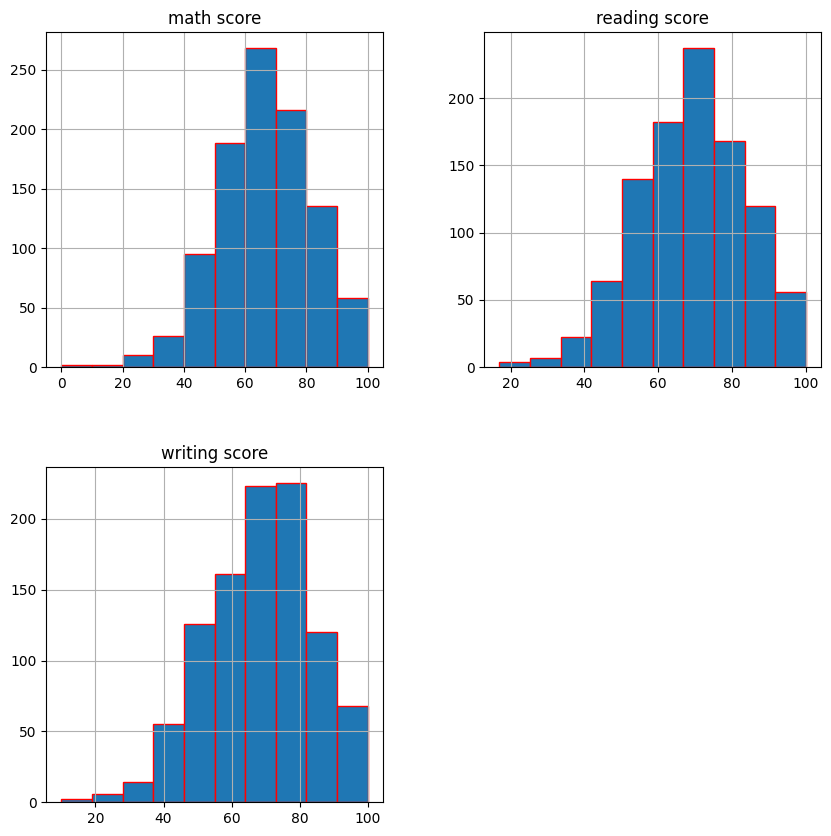

In [310]:
# Visualisation of numerical columns distributions :

df.hist(figsize=(10,10), bins=10,edgecolor="red")

plt.show()

### There is a way to combine step 2 and step 4 into one command using the "ydata-profiling" library to get a complete report on step 2 and step 4

In [311]:
# After using it, comment it out so it runs only once, 
# that's enough because it only shows us the unprocessed data at first.

# from ydata_profiling import ProfileReport

# profile = ProfileReport(df, title="Regression - Student Score Report")
# profile.to_file("Regression_Report.html")

![image.png](Report_correlation.png)

In the report file in the `Correlations` section (image above), it should be noted that when the dataset contains both numerical and categorical data, only the correlation between numerical value columns is of interest because this report file will automatically digitize the categorical values ​​(digitize in alphabetical order and then convert to numbers), so the correlation of the categorical value columns is no longer accurate.

So the correlation values ​​of the categorical columns will be ignored and only the correlation between the numerical value columns will be of interest.

In [312]:
# Vậy để dễ xem thì ta code thẳng để xem correlation giữa 3 cột numerical trong dataset

correlations = df.corr(numeric_only=True)
# correlations = df[["math score", "reading score", "writing score"]].corr()

print(correlations)

               math score  reading score  writing score
math score           1.00           0.82           0.80
reading score        0.82           1.00           0.95
writing score        0.80           0.95           1.00


### Step before data preprocessing step (step 3): data division step

A. Identify features and target

In [313]:
# Identify target
target = "math score"

x = df.drop(target, axis=1) # Split the X columns (feature columns)
y = df[target] # Split the Y column (target)
y

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math score, Length: 1000, dtype: int64

B. Identify train set, validation test and test set

In [314]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

x_train

,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
29,female,group D,master's degree,standard,none,70,75
535,female,group C,bachelor's degree,free/reduced,completed,83,83
695,female,group D,some college,free/reduced,none,89,86
557,male,group C,master's degree,free/reduced,none,67,66
836,male,group E,high school,standard,none,64,57
...,...,...,...,...,...,...,...
106,female,group D,master's degree,standard,none,100,100
270,male,group C,bachelor's degree,standard,none,63,61
860,female,group C,associate's degree,standard,none,62,53
435,male,group C,some college,free/reduced,completed,48,53


### Step 3 : Data pre-processing
#### Step 3.1 : Preprocessing NUMERICAL FEATURE

Here this is `reading score` and `writing score` columns

In [315]:
num_transformer = Pipeline([("imputer", SimpleImputer(strategy="median")), 
                           ("scaler", RobustScaler())])

# Done with preprocessing pipeline, now fit_transform
processed_num_data = num_transformer.fit_transform(x_train[["reading score", "writing score"]])

# Now I just want to check the first 5 values ​​before and after preprocessing the data
for idx, (i, j) in enumerate(zip(x_train[["reading score", "writing score"]].values, processed_num_data)):
    if idx >= 5:
        break
    print(f'{idx}, not processed data is {i}, processed data is {j}')

0, not processed data is [70 75], processed data is [0.         0.28571429]
1, not processed data is [83 83], processed data is [0.65       0.66666667]
2, not processed data is [89 86], processed data is [0.95       0.80952381]
3, not processed data is [67 66], processed data is [-0.15       -0.14285714]
4, not processed data is [64 57], processed data is [-0.3        -0.57142857]


#### Step 3.2 : Preprocessing CATEGORICAL ORDINAL and CATEGORICAL BOOLEAN FEATURES

Here :
- CATEGORICAL ORDINAL : this is `parental level of education` column
- CATEGORICAL BOOLEAN : this is `gender`, `lunch`, `test preparation course` columns

In [316]:
# Unique values ​​of the column "parental level of education"
print(df["parental level of education"].unique())

["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']


Here we choose the following order:

0. some high school
1. high school
2. some college
3. bachelor's degree
4. associate's degree
5. master's degree

In [317]:
# List the order of the values ​​of the "parental level of education" column (ORDINAL type)
order_feature = ['some high school', 'high school', 'some college', "bachelor's degree", "associate's degree", "master's degree"]

# List the order of the values ​​of the BOOLEAN type columns 
gender_order = ["male", "female"] # gender_order = df["gender"].unique()
lunch_order = df["lunch"].unique()
test_order = df["test preparation course"].unique()

ordinal_boolean_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),
                               ("ord_encoder", OrdinalEncoder(categories= [order_feature, gender_order, lunch_order, test_order]))])

processed_ordinal_boolean_data = ordinal_boolean_transformer.fit_transform(x_train[["parental level of education", "gender", "lunch", "test preparation course"]])

# Check the first 10 values ​​before and after data preprocessing
for idx, (i, j)  in enumerate(zip(x_train[["parental level of education", "gender", "lunch", "test preparation course"]].values, processed_ordinal_boolean_data)):
    if idx >= 10:
        break 
    print(f'{idx}, not-processed data is {i}, processed data is {j}')

0, not-processed data is ["master's degree" 'female' 'standard' 'none'], processed data is [5. 1. 0. 0.]
1, not-processed data is ["bachelor's degree" 'female' 'free/reduced' 'completed'], processed data is [3. 1. 1. 1.]
2, not-processed data is ['some college' 'female' 'free/reduced' 'none'], processed data is [2. 1. 1. 0.]
3, not-processed data is ["master's degree" 'male' 'free/reduced' 'none'], processed data is [5. 0. 1. 0.]
4, not-processed data is ['high school' 'male' 'standard' 'none'], processed data is [1. 0. 0. 0.]
5, not-processed data is ['high school' 'male' 'free/reduced' 'none'], processed data is [1. 0. 1. 0.]
6, not-processed data is ["bachelor's degree" 'female' 'standard' 'completed'], processed data is [3. 1. 0. 1.]
7, not-processed data is ["associate's degree" 'female' 'standard' 'completed'], processed data is [4. 1. 0. 1.]
8, not-processed data is ['high school' 'male' 'standard' 'completed'], processed data is [1. 0. 0. 1.]
9, not-processed data is ['some hig

#### Step 3.3 : Preprocessing CATEGORICAL NOMINAL FEATURE

Here, this is `race/ethnicity` column

In [318]:
nominal_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")), 
                               ("nom_encoder", OneHotEncoder(sparse_output=False))])

processed_nominal_data = nominal_transformer.fit_transform(x_train[["race/ethnicity"]])

# Check the first 10 values ​​before and after data preprocessing
for idx, (i, j)  in enumerate(zip(x_train[["race/ethnicity"]].values, processed_nominal_data)):
    if idx < 10:
        print(f'not processed data is {i}, processed data is {j}')

not processed data is ['group D'], processed data is [0. 0. 0. 1. 0.]
not processed data is ['group C'], processed data is [0. 0. 1. 0. 0.]
not processed data is ['group D'], processed data is [0. 0. 0. 1. 0.]
not processed data is ['group C'], processed data is [0. 0. 1. 0. 0.]
not processed data is ['group E'], processed data is [0. 0. 0. 0. 1.]
not processed data is ['group B'], processed data is [0. 1. 0. 0. 0.]
not processed data is ['group C'], processed data is [0. 0. 1. 0. 0.]
not processed data is ['group C'], processed data is [0. 0. 1. 0. 0.]
not processed data is ['group D'], processed data is [0. 0. 0. 1. 0.]
not processed data is ['group C'], processed data is [0. 0. 1. 0. 0.]


#### Step 3 : SUMMARY

Combine all of this step 3 and store it in a variable for easy application to data

In [319]:
preprocessor = ColumnTransformer(transformers= [
    ("num_features", num_transformer, ["reading score", "writing score"]),
    ("ordinal_bool_features", ordinal_boolean_transformer, ["parental level of education", "gender", "lunch", "test preparation course"]),
    ["nominal_features", nominal_transformer, ["race/ethnicity"]]
])
preprocessor

,transformers,"[('num_features', ...), ('ordinal_bool_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


#### Step 3 : Check the structure of this dataset after this step



In [320]:
step_preprocessing = Pipeline(steps= [
    ("preprocessor", preprocessor)
])

processed_data = step_preprocessing.fit_transform(x_train)
view_processed_data = pd.DataFrame(processed_data)
view_processed_data

,0,1,2,3,4,5,6,7,8,9,10
0,0.00,0.29,5.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,0.65,0.67,3.00,1.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00
2,0.95,0.81,2.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
3,-0.15,-0.14,5.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
4,-0.30,-0.57,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...
795,1.50,1.48,5.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
796,-0.35,-0.38,3.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
797,-0.40,-0.76,4.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
798,-1.10,-0.76,2.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00


### Step 5: Choose a model

As we saw in step 2+4 (data viewing step), the target column has a large correlation system for the 2 numerical features columns, so the first thing I think of is choosing **LINEAR MODEL**

5.1) First Model :  `LinearRegression` from `sklearn.linear_model`

In [321]:
# I re-use the Pipeline function again to train the model
model1 = Pipeline(steps= [
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

model1.fit(x_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_features', ...), ('ordinal_bool_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [322]:
# Store model for reuse in many different situations
filename = 'Model_LinearRegression.pkl'
pickle.dump(model1,open('Model_LinearRegression.pkl', 'wb'))

5.1) Second Model :  `RandomForestRegressor` from `sklearn.ensemble`

In [323]:
model2 = Pipeline(steps= [
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

model2.fit(x_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_features', ...), ('ordinal_bool_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [324]:
# Store model for reuse in many different situations
filename = 'Model_RandomForest.pkl'
pickle.dump(model2,open('Model_RandomForest.pkl', 'wb'))

### Step 6: Model evaluating


In [325]:
# Recall models from pickle
model1_pickle = pickle.load(open('Model_LinearRegression.pkl','rb'))
model2_pickle = pickle.load(open('Model_RandomForest.pkl','rb'))

y_predit1 = model1_pickle.predict(x_test)
y_predit2 = model2_pickle.predict(x_test)

<ins>Metrics for Linear Regression Model</ins>

In [326]:
print(f"MAE of Linear Regression Model: {mean_absolute_error(y_test, y_predit1)}")
print(f"MSE of Linear Regression Model: {mean_squared_error(y_test, y_predit1)}")
print(f"R2 of Linear Regression Model: {r2_score(y_test, y_predit1)}")

MAE of Linear Regression Model: 4.190585886246103
MSE of Linear Regression Model: 29.134955058659525
R2 of Linear Regression Model: 0.8802698009904745


<ins>Metrics for Random Forest Model</ins>

In [327]:
print(f"MAE of Random Forest Model: {mean_absolute_error(y_test, y_predit2)}")
print(f"MSE of Random Forest Model: {mean_squared_error(y_test, y_predit2)}")
print(f"R2 of Linear Regression Model: {r2_score(y_test, y_predit2)}")

MAE of Random Forest Model: 4.708507142857143
MSE of Random Forest Model: 37.415056136196156
R2 of Linear Regression Model: 0.8462426968526293


### (BONUS PART 1) Another way after preprocessing step to run the model : Re-optimize the model using GridSearchCV and RandomizedSearchCV to find hyper-parameters before running the model

Testing in Random Forest Model

In [328]:
model2_optimize = Pipeline(steps= [
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

params = {
    "regressor__n_estimators" : [50,100,200],
    "regressor__criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    "regressor__max_depth": [None, 2, 5, 10],
    "regressor__min_samples_split" : [2, 5],
    "preprocessor__num_features__imputer__strategy" : ["median", "mean"]
}

gridsearchcv_model2_optimize = GridSearchCV(model2_optimize, param_grid=params, 
                     scoring="r2", cv=6, verbose=2, n_jobs=-1)

# randomizedsearchcv_model2_optimize = RandomizedSearchCV(model2_optimize, param_grid=params, n_iter=20 
#                      scoring="r2", cv=6, verbose=2, n_jobs=-1)

I let the machine learn and predict based on the model optimized by GridSearchCV

In [329]:
gridsearchcv_model2_optimize.fit(x_train, y_train)
y_predict_optimize = gridsearchcv_model2_optimize.predict(x_test)

Fitting 6 folds for each of 192 candidates, totalling 1152 fits


In [330]:
# Since GridSearchCV is based on the Cross-validation principle, these are the points based on the VALIDATION set
print(gridsearchcv_model2_optimize.best_params_)
print(gridsearchcv_model2_optimize.best_score_) # this is the score based on the best R2 parameter on the VALIDATION set

# and here are the scores based on the TEST set
print(f"MAE : {mean_absolute_error(y_test, y_predict_optimize)}")
print(f"MSE : {mean_squared_error(y_test, y_predict_optimize)}")
print(f"r2 : {r2_score(y_test, y_predict_optimize)}") # this is the score based on the best R2 parameter on the TEST set

{'preprocessor__num_features__imputer__strategy': 'median', 'regressor__criterion': 'absolute_error', 'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
0.8351758071932608
MAE : 4.552125
MSE : 35.514881562499994
r2 : 0.8540514708632094


### (BONUS PART 2) Another way to approach data modeling and data evaluation phases : LazyPredict library

LazyPredict function in lazypredict library is fast train function in Machine Learning Supervised and return 30 suitable models

In [331]:
applied_step_preprocessing_to_features = Pipeline(steps= [
    ("preprocessor", preprocessor)
])

x_train_for_lazypredict = applied_step_preprocessing_to_features.fit_transform(x_train)
x_test_for_lazypredict = applied_step_preprocessing_to_features.transform(x_test) # Ng.lý : chỉ transform trên bộ test

clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None, random_state=42)
clf.use_notebook_tqdm = False  # Tắt tqdm trong Jupyter
models, predictions = clf.fit(x_train_for_lazypredict, x_test_for_lazypredict, y_train, y_test)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 158
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 11
[LightGBM] [Info] Start training from score 66.496250
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [ ]:
models_sorted = models.sort_values(by=["Adjusted R-Squared","Time Taken"], ascending=[False, True])

view_lazypredict_models = pd.DataFrame(models_sorted)
view_lazypredict_models[["Adjusted R-Squared", "Time Taken"]] = view_lazypredict_models[["Adjusted R-Squared", "Time Taken"]].apply(pd.to_numeric, errors='coerce')

view_lazypredict_models.style.format({
    "Adjusted R-Squared": "{:.5f}",
    "Time Taken": "{:.5f}"
})


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
SGDRegressor,0.87389,0.880863,5.384301,0.01006
ElasticNetCV,0.87369,0.880669,5.388683,0.03618
HuberRegressor,0.87354,0.880530,5.391815,0.02236
LassoCV,0.87349,0.880479,5.392959,0.12609
BayesianRidge,0.87348,0.880472,5.393124,0.00852
RidgeCV,0.87340,0.880402,5.394692,0.00999
Ridge,0.87340,0.880402,5.394692,0.00706
TransformedTargetRegressor,0.87326,0.880270,5.397681,0.00621
Lars,0.87326,0.880270,5.397681,0.01468


Show top 5 as horizontal bar chart

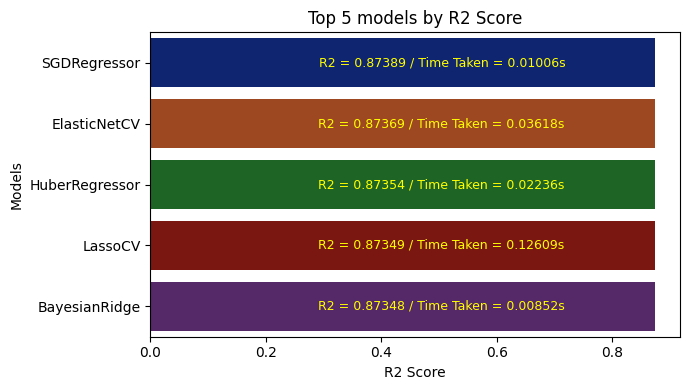

In [351]:
top5_R2 = view_lazypredict_models.head(5)

plt.figure(figsize=(7,4))
ax = sns.barplot(
    data=top5_R2,
    x="Adjusted R-Squared",
    y="Model",
    palette="dark",
    orient="h"
)

plt.title("Top 5 models by R2 Score")
plt.xlabel("R2 Score")
plt.ylabel("Models")


# Add Time Taken and Accuracy labels to each bar
for i, (r2, time) in enumerate(zip(top5_R2["Adjusted R-Squared"], top5_R2["Time Taken"])):
    ax.text(
        r2/3,                                                     
        i,                                                          
        f"R2 = {r2:.5f} / Time Taken = {time:.5f}s",         
        va="center",                                              
        fontsize=9,
        color="yellow"
    )

plt.tight_layout()
plt.show()

<div align="center">

### - END -

</div>
